In [1]:
import pathlib
from google3.pyglib import gfile
from google3.pyglib import resources
import tqdm
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import xarray
import time
import matplotlib.cm as cm
import scipy

In [2]:
from colabtools import adhoc_import
with adhoc_import.Google3Head():
  from google3.intelligence.greenseer.colab.utils.import_utils import dynamic_import, reload_buttons, reload_all, import_proto, register_objects_for_class_reloads

client = 'gsnearing@data_assimilation'
with dynamic_import(client, package_restrict='google3.experimental'):
  from google3.experimental.projects.flood_forecasting.minimal_lstm import metrics as calc_metrics

In [3]:
# pd.set_option('display.max_rows', 500)

In [4]:
def nse(y, y_hat):
  idx = (~np.isnan(y)) & (~np.isnan(y_hat))
  return 1 - np.nansum((y[idx] - y_hat[idx])**2) / np.nansum((y[idx] - np.nanmean(y[idx]))**2)

In [5]:
# load list of basins
basin_file = pathlib.Path("/cns/jn-d/home/floods/hydro_model/work/gsnearing/lstm_based_hydrology/531_basin_list.txt")
with gfile.Open(basin_file, "r") as fp:
  basins_txt = fp.read()
basins = sorted(basin.strip() for basin in basins_txt.split("\n"))
basins = [basin for basin in basins if basin] 
print(f"There are {len(basins)} basins.")

There are 531 basins.


In [6]:
# date range
dates = pd.date_range('10/01/1989', '09/30/1999')
print(f"There are {len(dates)} validation timesteps.")

There are 3652 validation timesteps.


In [7]:
# experiment dimensions
run_dir = pathlib.Path("/cns/jn-d/home/floods/hydro_model/work/gsnearing/lstm_based_hydrology/assimilation_experiments/runs/")
run_types = [
             'base_model',
             'base_model_states',
             'base_model_inputs',
             'base_model_both',
             'lagged_streamflow',
             'lagged_streamflow_states',             
             'lagged_streamflow_inputs',             
             'lagged_streamflow_both',             
             ]
metric_names = [
                'NSE',
                'KGE',
                'Alpha-NSE',
                'Pearson-r',
                'Beta-NSE',
                'FHV',
                'FMS',
                'FLV',
                'Peak-Timing'
            ]
repetitions = list(range(10))

In [8]:
# load observations
observations = pd.DataFrame(index=dates, columns=basins)

files = gfile.Glob(run_dir / f'base_model_run_repetition_0_*' / 'val' / '020_results.p')
with gfile.Open(files[0], 'rb') as f:
  data = pkl.load(f)

for basin in tqdm.tqdm(basins):
  observations[basin] = data[basin]['1D']['xr']['QObs(mm/d)_obs'].values

Exception in thread Thread-3:
Traceback (most recent call last):
  File "/export/hda3/borglet/remote_hdd_fs_dirs/0.gsnearing_ff_colab_kernel.kernel.gsnearing.322910433717.14b334fb3717c109/mount/server/notebook.par/google3/third_party/py/debugpy/server/api.py", line 213, in listen
    sock, _ = endpoints_listener.accept()
  File "<embedded stdlib>/socket.py", line 205, in accept
    fd, addr = self._accept()
socket.timeout: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<embedded stdlib>/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<embedded stdlib>/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/export/hda3/borglet/remote_hdd_fs_dirs/0.gsnearing_ff_colab_kernel.kernel.gsnearing.322910433717.14b334fb3717c109/mount/server/notebook.par/google3/research/colab/lib/_debugpy.py", line 28, in attachment_entry
    debugpy.listen((_domain_socket_name, 0))
  Fi

In [9]:
metrics = pd.DataFrame(index=basins, columns=pd.MultiIndex.from_product([metric_names, run_types, repetitions, repetitions]))
running_mean = np.zeros((len(dates), len(basins), len(run_types)))

for t, run_type in enumerate(run_types):
  base_run_type =  "_".join(run_type.split('_')[:2])
  for r, rep in tqdm.tqdm(enumerate(repetitions)):
    
    if "states" in run_type: 
      # files = gfile.Glob(run_dir / f'{base_run_type}_run_repetition_{rep}_*' / f'assimilation_1_5_150_both_0.001_0.99_10' / '020_results.p')
      files = gfile.Glob(run_dir / f'{base_run_type}_run_repetition_{rep}_*' / f'assimilation_1_5_1000_states_*_repetition_*/' / '020_results.p')
    elif "both" in run_type:
      # files = gfile.Glob(run_dir / f'{base_run_type}_run_repetition_{rep}_*' / f'assimilation_1_5_150_both_0.001_0.99_10' / '020_results.p')
      files = gfile.Glob(run_dir / f'{base_run_type}_run_repetition_{rep}_*' / f'assimilation_1_5_1000_both_*_repetition_*/' / '020_results.p')
    elif "inputs" in run_type:
      # files = gfile.Glob(run_dir / f'{base_run_type}_run_repetition_{rep}_*' / f'assimilation_1_5_150_inputs_0.001_0.99_10' / '020_results.p')
      files = gfile.Glob(run_dir / f'{base_run_type}_run_repetition_{rep}_*' / f'assimilation_1_5_1000_inputs_*_repetition_*/' / '020_results.p')
    else:
      files = gfile.Glob(run_dir / f'{base_run_type}_run_repetition_{rep}_*' / 'val' / '020_results.p')

    with gfile.Open(files[0], 'rb') as f:
      data = pkl.load(f)

    for b, basin in enumerate(basins):
      running_mean[:,b,t] = running_mean[:,b,t] + np.squeeze(data[basin]['1D']['xr']['QObs(mm/d)_sim'].values)
      
      for metric in metric_names:
        metrics.loc[basin, (metric, run_type, rep, 0)] = data[basin]['1D'][metric]

10it [01:12,  7.23s/it]
10it [01:12,  7.29s/it]
10it [01:13,  7.43s/it]
10it [01:12,  7.13s/it]
10it [01:14,  7.47s/it]
10it [01:15,  7.56s/it]
10it [01:18,  7.95s/it]
10it [01:16,  7.38s/it]


In [10]:
simulations = pd.DataFrame(index=dates, columns=pd.MultiIndex.from_product([basins, run_types]))
for t, run_type in enumerate(run_types):
  for b, basin in tqdm.tqdm(enumerate(basins)):
    simulations[(basin, run_type)] = running_mean[:,b,t] / len(repetitions)
simulations

531it [01:29,  8.16it/s]
531it [01:24,  7.02it/s]
531it [00:59, 15.58it/s]
531it [00:36, 14.66it/s]
531it [00:34, 15.50it/s]
531it [00:37, 14.04it/s]
531it [00:22, 23.85it/s]
531it [00:06, 77.90it/s] 


01022500  ...               14400000
           base_model  ... lagged_streamflow_both
1989-10-01   0.680212  ...               0.256904
1989-10-02   0.620942  ...               0.246520
1989-10-03   0.903806  ...               0.250368
1989-10-04   1.113886  ...               0.238079
1989-10-05   0.998115  ...               0.237953
...               ...  ...                    ...
1999-09-26   2.718350  ...               0.177874
1999-09-27   2.119984  ...               0.170473
1999-09-28   1.661644  ...               0.156378
1999-09-29   1.358696  ...               0.150563
1999-09-30   1.119304  ...               0.158204

[3652 rows x 4248 columns]

In [11]:
# save progress
with gfile.Open('/cns/jn-d/home/floods/hydro_model/work/gsnearing/lstm_based_hydrology/assimilation_experiments/results/observations.pkl', 'wb') as f:
  pkl.dump(observations, f)

with gfile.Open('/cns/jn-d/home/floods/hydro_model/work/gsnearing/lstm_based_hydrology/assimilation_experiments/results/simulations.pkl', 'wb') as f:
  pkl.dump(simulations, f)

with gfile.Open('/cns/jn-d/home/floods/hydro_model/work/gsnearing/lstm_based_hydrology/assimilation_experiments/results/individual_run_metrics.pkl', 'wb') as f:
  pkl.dump(metrics, f)

In [12]:
# init storage
ensemble_metrics = pd.DataFrame(index=basins, columns=pd.MultiIndex.from_product([metric_names, run_types]))

# calculate ensemble metrics
for basin in tqdm.tqdm(basins):
  for run_type in run_types:

    df = pd.concat([simulations[(basin, run_type)], observations[basin]], axis=1)
    xr = xarray.Dataset.from_dataframe(df)
    obs = xr[basin]
    sim = xr[(basin, run_type)]
    obs = obs.rename({'index':'datetime'})
    sim = sim.rename({'index':'datetime'})
    calc_metrics.calculate_metrics(obs=obs, sim=sim, metrics=metric_names, resolution='1D')

    basin_metric_values = calc_metrics.calculate_metrics(obs=obs, sim=sim, metrics=metric_names, resolution='1D')

    for metric in metric_names:
      ensemble_metrics.loc[basin, (metric, run_type)] = basin_metric_values [metric]

# save progress
with gfile.Open('/cns/jn-d/home/floods/hydro_model/work/gsnearing/lstm_based_hydrology/assimilation_experiments/results/ensemble_metrics.pkl', 'wb') as f:
  pkl.dump(ensemble_metrics, f)

100%|██████████| 531/531 [19:42<00:00,  2.57s/it]


In [13]:
printable_df = pd.DataFrame(columns=run_types, index=pd.MultiIndex.from_product([metric_names, ['median', 'mean']]))
for metric in metric_names:
  for run_type in run_types:
    printable_df.loc[(metric,'mean'), run_type] = ensemble_metrics[(metric, run_type)].mean()
    printable_df.loc[(metric,'median'), run_type] = ensemble_metrics[(metric, run_type)].median()
printable_df

base_model  ... lagged_streamflow_both
NSE         median     0.812837  ...               0.887193
            mean        0.77778  ...               0.857008
KGE         median     0.799806  ...               0.890367
            mean       0.750852  ...               0.858089
Alpha-NSE   median     0.855414  ...               0.921848
            mean       0.843028  ...               0.901661
Pearson-r   median     0.913028  ...               0.943416
            mean       0.894608  ...                0.92881
Beta-NSE    median   -0.0285986  ...            -0.00690776
            mean     -0.0328339  ...            -0.00724097
FHV         median      -14.658  ...               -8.10151
            mean       -15.1054  ...               -8.89667
FMS         median     -5.51767  ...              -0.511819
            mean         168201  ...                 255068
FLV         median      -27.601  ...               -46.0766
            mean   -1.51671e+10  ...           -8.26283e+09
Peak-Timing median     0.235294  ...                   0.35
            mean        0.35511  ...               0.415729

[18 rows x 8 columns]

In [14]:
statistic = {}
pvalue = {}
for metric in metric_names:
  bm = ensemble_metrics[(metric, 'base_model')].to_numpy(dtype=float)
  da = ensemble_metrics[(metric, 'base_model_states')].to_numpy(dtype=float)
  ar = ensemble_metrics[(metric, 'lagged_streamflow')].to_numpy(dtype=float)
  statistic[metric], pvalue[metric] = scipy.stats.wilcoxon(da,ar)
pvalue

{'NSE': 4.168816808004315e-42,
 'KGE': 5.268619318047203e-32,
 'Alpha-NSE': 1.698148060418295e-24,
 'Pearson-r': 2.45507350720333e-41,
 'Beta-NSE': 8.879906220925104e-47,
 'FHV': 9.383786610138067e-22,
 'FMS': 0.0002736998020321888,
 'FLV': 0.0002048620863846799,
 'Peak-Timing': 6.308911881673985e-36}

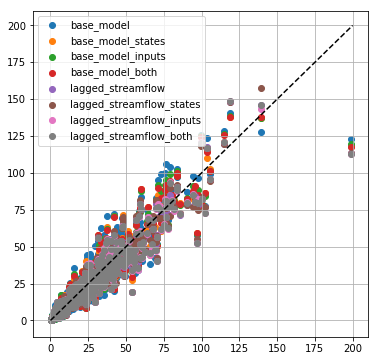

In [15]:
basins = basins[0]
plt.figure(figsize=(6,6))
for run_type in run_types:
  plt.scatter(observations[basin], simulations[(basin, run_type)], label=run_type)
plt.plot([0,200], [0,200], 'k--')
plt.legend()
plt.grid()

4it [00:00, 72.47it/s]


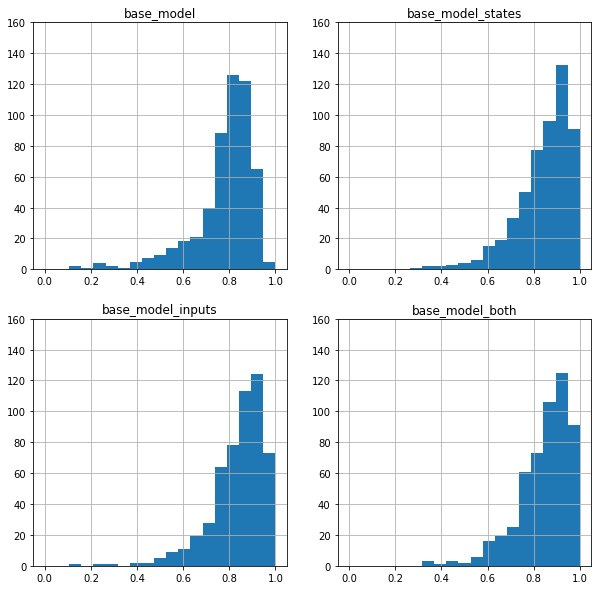

In [16]:
metric = 'NSE'
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for ai, ax in tqdm.tqdm(enumerate(axes.flatten())):
  # plotdata = np.maximum(0, ensemble_metrics[(metric, run_types[ai])].to_numpy(dtype=float))
  plotdata = ensemble_metrics[(metric, run_types[ai])].to_numpy(dtype=float)
  ax.hist(plotdata, bins=np.linspace(0,1,20))
  # ax.set_xlim([0,1])
  ax.set_ylim([0,160])
  ax.set_title(run_types[ai])
  ax.grid()

4it [00:00, 169.81it/s]


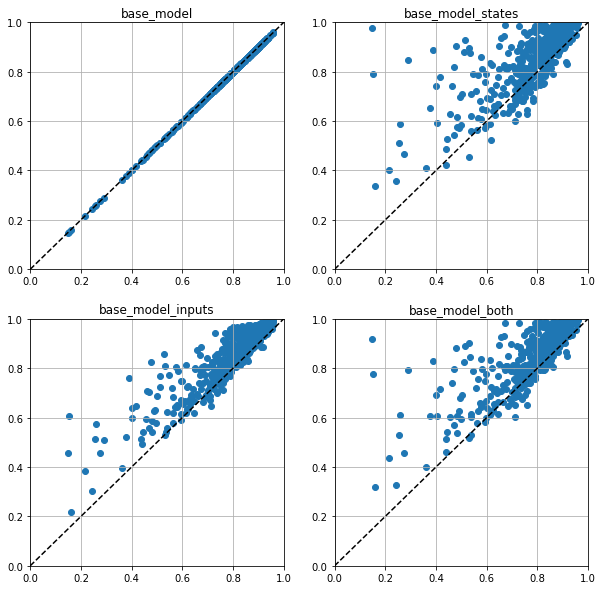

In [17]:
metric = 'NSE'
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for ai, ax in tqdm.tqdm(enumerate(axes.flatten())):
  ax.scatter(ensemble_metrics[(metric, 'base_model')].to_numpy(dtype=float), ensemble_metrics[(metric, run_types[ai])].to_numpy(dtype=float))   
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0, 1])
  ax.set_ylim([0, 1])
  ax.set_title(run_types[ai])
  ax.grid()

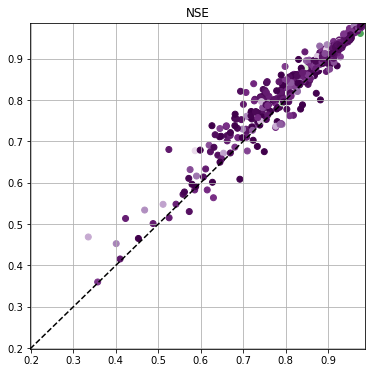

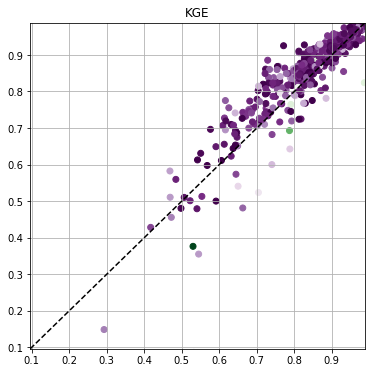

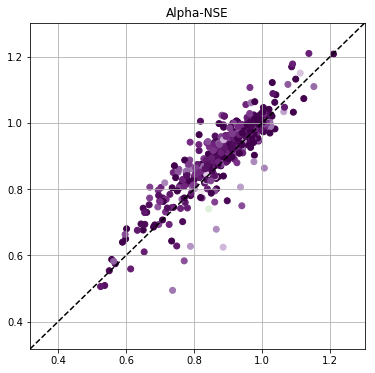

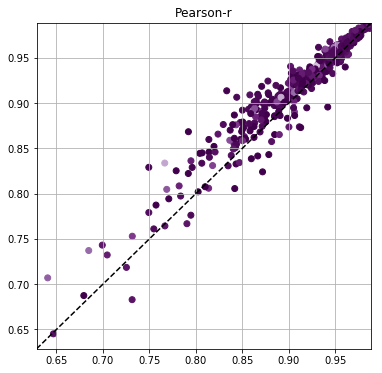

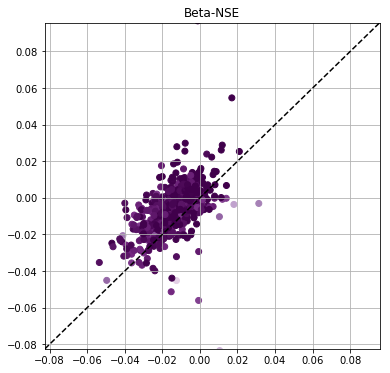

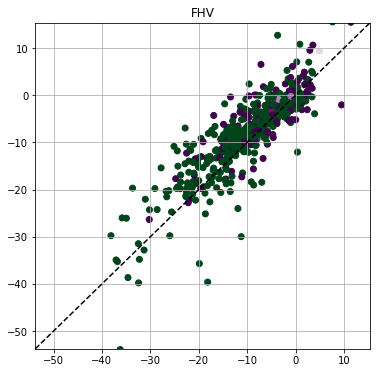

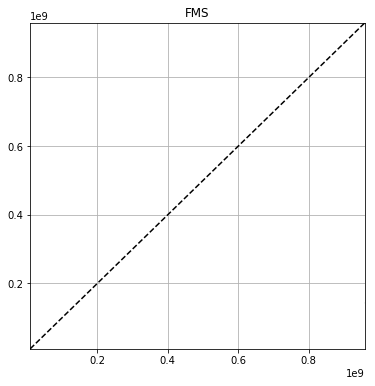

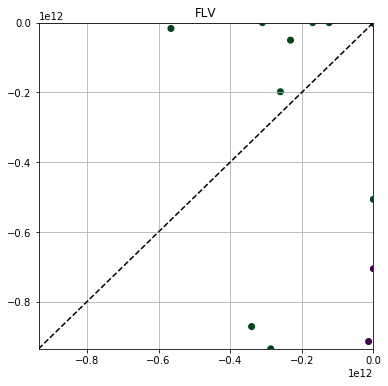

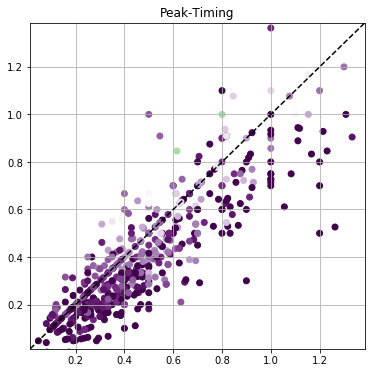

In [18]:
for metric in metric_names:
  plt.figure(figsize=(6,6))
  bm = ensemble_metrics[(metric, 'base_model')].to_numpy(dtype=float)
  da = ensemble_metrics[(metric, 'base_model_states')].to_numpy(dtype=float)
  ar = ensemble_metrics[(metric, 'lagged_streamflow')].to_numpy(dtype=float)
  colors = cm.PRGn(ar-bm)
  plt.scatter(da, ar, color=colors)
  plt.title(metric)
  xmax = np.max([np.max(da), np.max(ar)])
  xmin = np.min([np.min(da), np.min(ar)]) + 0.01*xmax
  xmax = xmax*0.99
  plt.plot([xmin, xmax], [xmin, xmax], 'k--')
  plt.axis([xmin, xmax, xmin, xmax])
  plt.grid()

In [19]:

# Relative attributes path (only works with how the data is stored on CNS).
attributes_path = pathlib.Path('/cns/jn-d/home/floods/hydro_model/work/gsnearing/camels_data/') / "camels_attributes_v2.0" / "camels_attributes_v2.0"

# Read all attributes files in the directory - assumes everything is ascii.
txt_files = gfile.Glob(attributes_path / "camels_*.txt")
if not txt_files:
  txt_files = gfile.Glob(attributes_path / "**/camels_*.txt")

# Read-in attributes into one big dataframe.
dfs = []
for txt_file in txt_files:
  df_temp = pd.read_csv(
      gfile.Open(txt_file), sep=";", header=0, dtype={"gauge_id": str})
  df_temp = df_temp.set_index("gauge_id")
  dfs.append(df_temp)
attributes = pd.concat(dfs, axis=1)

# convert huc column to double digit strings
attributes["huc"] = attributes["huc_02"].apply(lambda x: str(x).zfill(2))
attributes = attributes.drop("huc_02", axis=1)

# drop rows of basins not contained in the passed list
drop_basins = [b for b in attributes.index if b not in basins]
attributes = attributes.drop(drop_basins, axis=0)

attributes

,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,high_prec_timing,low_prec_freq,low_prec_dur,low_prec_timing,geol_1st_class,glim_1st_class_frac,geol_2nd_class,glim_2nd_class_frac,carbonate_rocks_frac,geol_porostiy,geol_permeability,q_mean,runoff_ratio,slope_fdc,baseflow_index,stream_elas,q5,q95,high_q_freq,high_q_dur,low_q_freq,low_q_dur,zero_q_freq,hfd_mean,gauge_name,soil_depth_pelletier,soil_depth_statsgo,soil_porosity,soil_conductivity,max_water_content,sand_frac,silt_frac,clay_frac,water_frac,organic_frac,other_frac,gauge_lat,gauge_lon,elev_mean,slope_mean,area_gages2,area_geospa_fabric,frac_forest,lai_max,lai_diff,gvf_max,gvf_diff,dom_land_cover_frac,dom_land_cover,root_depth_50,root_depth_99,huc
gauge_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01022500,3.608126,2.119256,-0.11453,0.245259,0.587356,20.55,1.205279,son,233.65,3.662226,jja,Acid plutonic rocks,0.590658,Siliciclastic sedimentary rocks,0.164618,0.0,0.071,-14.2138,2.173062,0.602269,1.77628,0.554478,1.702782,0.204734,7.123049,3.9,2.294118,65.15,17.144737,0.0,166.25,"Narraguagus River at Cherryfield, Maine",17.412808,1.491846,0.415905,2.375005,0.626229,59.390156,28.080937,12.037646,1.226913,0.0,0.358472,44.60797,-67.93524,92.68,17.79072,573.6,620.38,0.9232,4.871392,3.746692,0.863936,0.337712,0.820493,Mixed Forests,0.237435,2.238444,01


ValueError: ignored

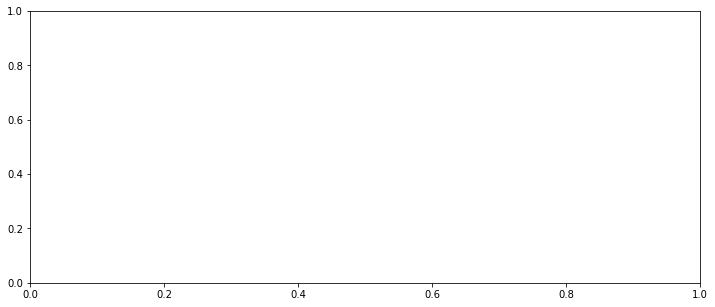

In [20]:
for metric in metric_names:
  fig = plt.figure(figsize=(12,5))
  bm = ensemble_metrics[(metric, 'base_model')].to_numpy(dtype=float)
  da = ensemble_metrics[(metric, 'base_model_states')].to_numpy(dtype=float)
  ar = ensemble_metrics[(metric, 'lagged_streamflow')].to_numpy(dtype=float)
  lat = attributes['gauge_lat']
  lon = attributes['gauge_lon']
  colors = ar-da
  cmax = np.max(np.abs(colors))
  colors[colors < 0] = -cmax*0.7
  colors[colors > 0] = cmax*0.7
  h = plt.scatter(lon, lat, vmin=-cmax, vmax=cmax, c=colors, cmap=cm.PRGn)
  plt.scatter(lon[colors == 0], lat[colors == 0], vmin=-cmax, vmax=cmax, color='b')
  plt.colorbar(h)
  plt.title(metric)

In [211]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

# prepare attributes as regressors
regressors = attributes.copy()
regressors = regressors.drop(["huc", "gauge_name"], axis=1)
regressors = regressors.dropna(axis=1)
cols = regressors.columns
for col in regressors.columns:
  if len(set(attributes[col])) < 30:
    regressors = pd.get_dummies(regressors, columns=[col], prefix=[col])
  else:
    regressors[col] = (regressors[col] - regressors[col].mean()) / regressors[col].std()
X = regressors.values

n_splits = 10

r2 = pd.DataFrame(index=metric_names, columns=run_types+["Delta-DA", "Delta-AR", "AR-DA"])

for run_type in run_types + ["Delta-DA", "Delta-AR", "AR-DA"]:
  print(run_type)
  for metric in tqdm.tqdm(metric_names):
    bm = ensemble_metrics[(metric, 'base_model')].to_numpy(dtype=float)
    da = ensemble_metrics[(metric, 'base_model_states')].to_numpy(dtype=float)
    ar = ensemble_metrics[(metric, 'lagged_streamflow')].to_numpy(dtype=float)
    difference = ar-da

    if run_type == "base_model":
      y = bm
    elif run_type == "base_model_states":
      y = da
    elif run_type == "lagged_streamflow":
      y = ar
    elif run_type == "Delta-DA":
      y = da-bm
    elif run_type == "Delta-AR":
      y = ar-bm
    elif run_type == "Delta-AR-DA":
      y = ar-da
    y = (y - np.mean(y)) / np.std(y)

    kf = KFold(n_splits=10)
    kf.get_n_splits(X)
    y_pred = np.full(len(basins), np.nan)
    for train_index, test_index in kf.split(X):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      regressor = RandomForestRegressor(n_estimators=100, random_state=0)
      regressor.fit(X_train, y_train)
      y_pred[test_index] = regressor.predict(X_test)

    r2.loc[metric, run_type] = metrics.r2_score(y, y_pred)
    # print(f'{metric} -- R2 = {r2.loc[metric, run_type]})

r2




  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:16<02:11, 16.48s/it]


 22%|██▏       | 2/9 [00:33<01:56, 16.63s/it]


 33%|███▎      | 3/9 [00:51<01:41, 16.96s/it]


 44%|████▍     | 4/9 [01:07<01:24, 16.89s/it]


 56%|█████▌    | 5/9 [01:25<01:08, 17.00s/it]


 67%|██████▋   | 6/9 [01:43<00:51, 17.32s/it]


 78%|███████▊  | 7/9 [02:04<00:37, 18.53s/it]


 89%|████████▉ | 8/9 [02:15<00:16, 16.22s/it]


100%|██████████| 9/9 [02:32<00:00, 16.56s/it]




base_model
base_model_states




  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:14<01:59, 14.95s/it]


 22%|██▏       | 2/9 [00:30<01:45, 15.09s/it]


 33%|███▎      | 3/9 [00:47<01:34, 15.79s/it]


 44%|████▍     | 4/9 [01:03<01:18, 15.76s/it]


 56%|█████▌    | 5/9 [01:19<01:03, 15.89s/it]


 67%|██████▋   | 6/9 [01:36<00:48, 16.07s/it]


 78%|███████▊  | 7/9 [02:00<00:37, 18.52s/it]


 89%|████████▉ | 8/9 [02:15<00:17, 17.59s/it]


100%|██████████| 9/9 [02:30<00:00, 16.66s/it]





lagged_streamflow




  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:15<02:05, 15.74s/it]


 22%|██▏       | 2/9 [00:31<01:50, 15.82s/it]


 33%|███▎      | 3/9 [00:50<01:40, 16.75s/it]


 44%|████▍     | 4/9 [01:05<01:21, 16.30s/it]


 56%|█████▌    | 5/9 [01:26<01:09, 17.47s/it]


 67%|██████▋   | 6/9 [01:43<00:52, 17.43s/it]


 78%|███████▊  | 7/9 [02:10<00:40, 20.31s/it]


 89%|████████▉ | 8/9 [02:27<00:19, 19.45s/it]


100%|██████████| 9/9 [02:43<00:00, 18.32s/it]





Delta-DA




  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:16<02:14, 16.80s/it]


 22%|██▏       | 2/9 [00:34<01:59, 17.09s/it]


 33%|███▎      | 3/9 [00:52<01:44, 17.34s/it]


 44%|████▍     | 4/9 [01:10<01:27, 17.54s/it]


 56%|█████▌    | 5/9 [01:28<01:11, 17.79s/it]


 67%|██████▋   | 6/9 [01:48<00:54, 18.20s/it]


 78%|███████▊  | 7/9 [02:09<00:38, 19.20s/it]


 89%|████████▉ | 8/9 [02:23<00:17, 17.50s/it]


100%|██████████| 9/9 [02:43<00:00, 18.31s/it]





Delta-AR




  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:19<02:34, 19.36s/it]


 22%|██▏       | 2/9 [00:38<02:15, 19.42s/it]


 33%|███▎      | 3/9 [00:58<01:57, 19.60s/it]


 44%|████▍     | 4/9 [01:19<01:39, 19.95s/it]


 56%|█████▌    | 5/9 [01:38<01:18, 19.63s/it]


 67%|██████▋   | 6/9 [01:57<00:58, 19.53s/it]


 78%|███████▊  | 7/9 [02:21<00:41, 20.70s/it]


 89%|████████▉ | 8/9 [02:42<00:20, 20.84s/it]


100%|██████████| 9/9 [03:03<00:00, 20.75s/it]





AR-DA




  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:20<02:43, 20.50s/it]


 22%|██▏       | 2/9 [00:39<02:21, 20.17s/it]


 33%|███▎      | 3/9 [00:59<01:59, 20.00s/it]


 44%|████▍     | 4/9 [01:19<01:39, 19.89s/it]


 56%|█████▌    | 5/9 [01:38<01:18, 19.71s/it]


 67%|██████▋   | 6/9 [01:59<01:00, 20.19s/it]


 78%|███████▊  | 7/9 [02:19<00:39, 19.95s/it]


 89%|████████▉ | 8/9 [02:38<00:19, 19.73s/it]


100%|██████████| 9/9 [02:57<00:00, 19.51s/it]




,base_model,base_model_states,lagged_streamflow,Delta-DA,Delta-AR,AR-DA
NSE,0.408282,0.480823,0.462829,0.395505,0.403707,-0.272206
KGE,0.350801,0.456484,0.402206,0.284045,0.227272,-0.275365
Alpha-NSE,0.142442,0.16009,0.0753745,0.286277,0.0899463,-0.280492
Pearson-r,0.464895,0.47198,0.45978,0.401688,0.381964,-0.27766
Beta-NSE,0.0529289,0.0756306,-0.0893788,0.0426253,0.0618864,-0.271284
FHV,0.131489,0.271941,0.151067,0.308626,0.120861,-0.285589
FMS,-0.0193166,-0.00659524,-0.00919936,-0.0044916,-0.00849999,-0.277487
FLV,0.561396,0.203586,0.40855,0.529004,-0.324589,-0.276233
Peak-Timing,0.448319,0.426745,0.436399,-0.116498,-0.273574,-0.279893


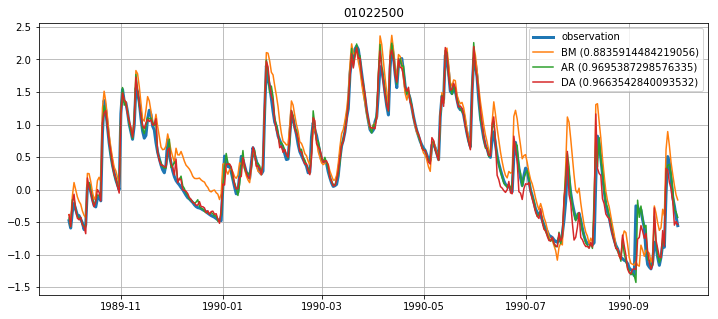

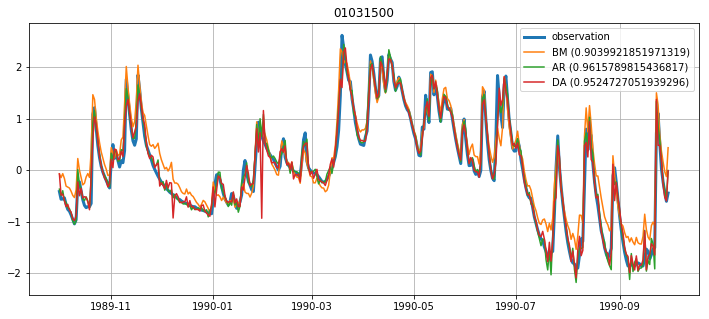

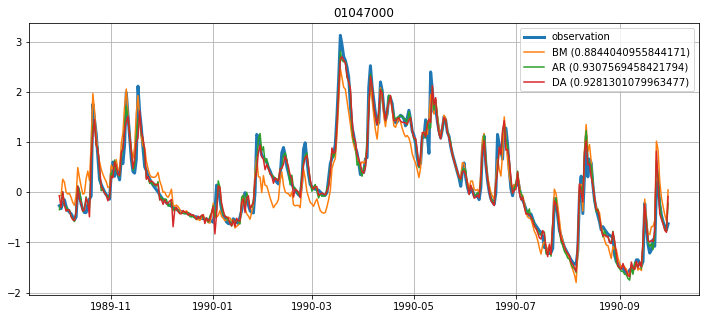

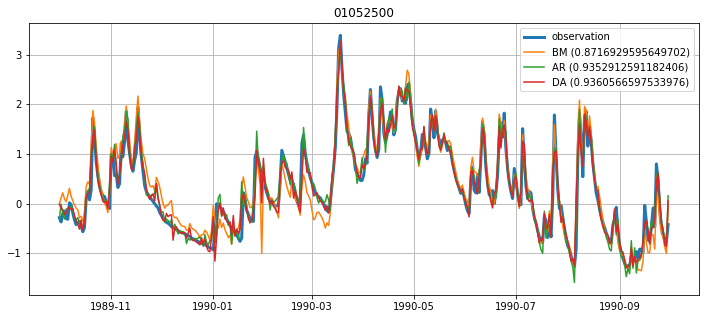

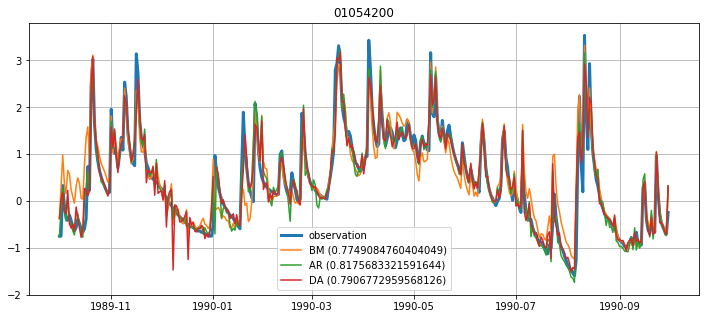

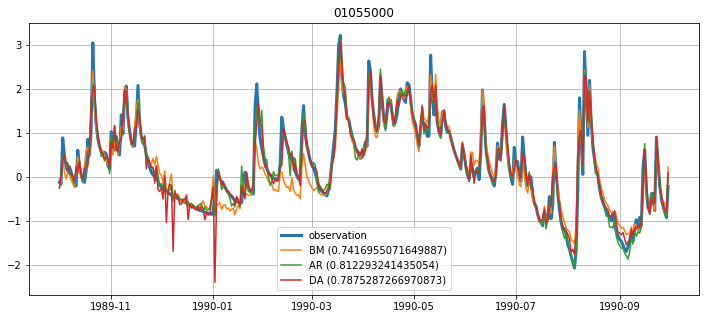

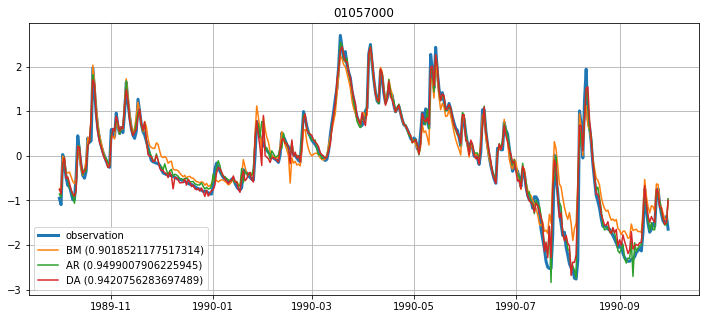

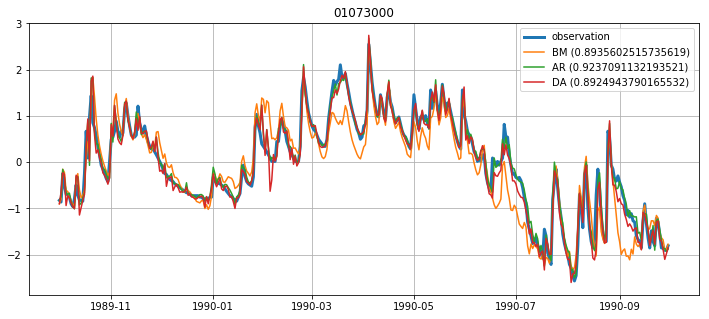

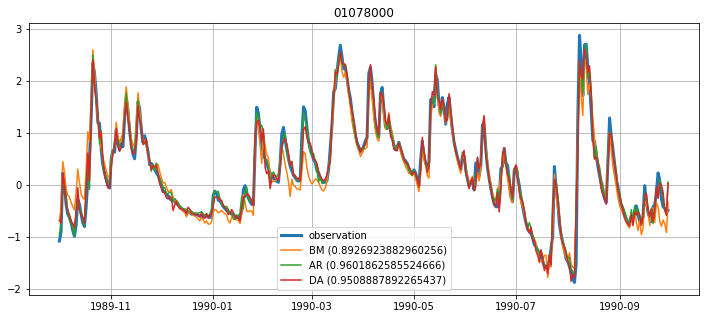

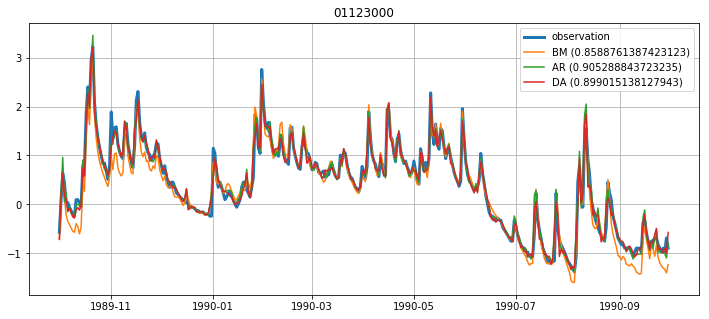

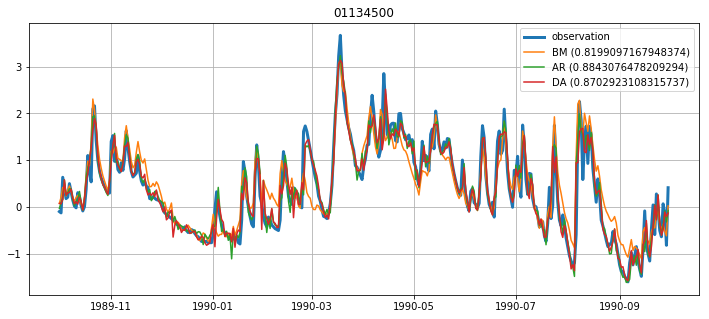

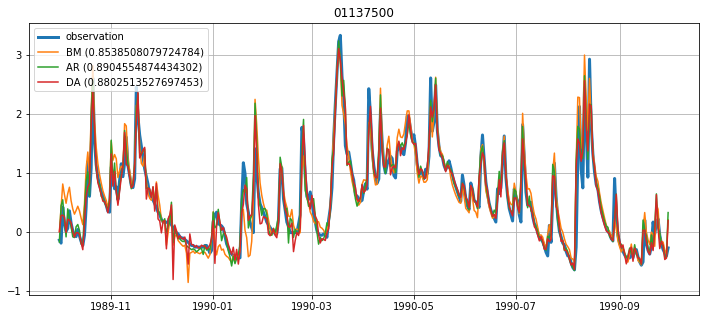

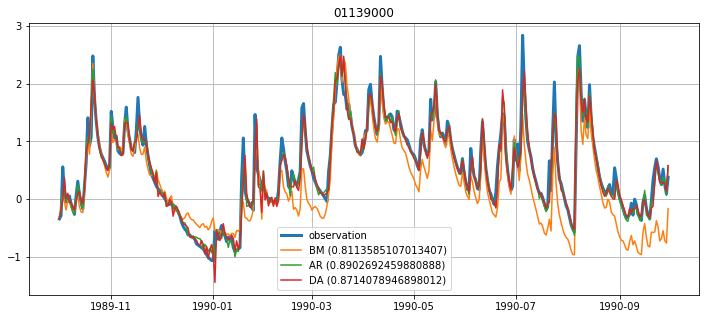

KeyboardInterrupt: ignored

In [221]:
metric = 'NSE'
for basin in basins:
  plt.figure(figsize=(12, 5))
  plt.plot(np.log(observations[(basin)].iloc[:365]), lw=3, label='observation')
  plt.plot(np.log(simulations[(basin, "base_model")].iloc[:365]), label=f"BM ({ensemble_metrics.loc[basin, (metric, 'base_model')]})")
  plt.plot(np.log(simulations[(basin, "lagged_streamflow")].iloc[:365]), label=f"AR ({ensemble_metrics.loc[basin, (metric, 'lagged_streamflow')]})")
  plt.plot(np.log(simulations[(basin, "base_model_states")].iloc[:365]), label=f"DA ({ensemble_metrics.loc[basin, (metric, 'base_model_states')]})")
  plt.grid()
  plt.legend()
  plt.title(basin)
  plt.show()